In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/10-monkey-species/monkey_labels.txt
/kaggle/input/10-monkey-species/validation/validation/n9/n9024.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n916.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n907.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n9030.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n918.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n902.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n914.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n912.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n9015.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n903.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n908.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n913.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n905.jpg
/kaggle/input/10-monkey-species/validation/validation/n9/n9013.jpg
/kaggle/input/10-monke

In [ ]:
# 在resnet50的网络上进行模型微调，迁移学习，50个层次的残差网络

In [12]:
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

1.14.0
sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.17.0
pandas 0.23.4
sklearn 0.21.3
tensorflow 1.14.0
tensorflow.python.keras.api._v1.keras 2.2.4-tf


In [18]:
train_dir = '../input/10-monkey-species/training/training'
valid_dir = '../input/10-monkey-species/validation/validation'
label_file = '../input/10-monkey-species/monkey_labels.txt'
print(os.path.exists(train_dir))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
['n9', 'n6', 'n8', 'n4', 'n3', 'n1', 'n5', 'n2', 'n0', 'n7']
['n9', 'n6', 'n8', 'n4', 'n3', 'n1', 'n5', 'n2', 'n0', 'n7']


In [19]:
# 读取数据
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [24]:
# 读取图片
# resnet50处理（224，224）的图片
height = 224
width =224   # 读取图片后对图片进行缩放,固定大小
channels = 3
batch_size = 24
num_classes = 10
# keras generator读取数据
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    # 为resnet50定义的预处理图像函数，在keras框架下
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    #rescale = 1./255.,  # 像素转为0-1
    rotation_range=40,# 图片随机旋转角度，40代表-40——40之间
    width_shift_range=0.2,# 水平位移，训练模型时使用数据和位移之后的数据
    height_shift_range=0.2,# 垂直位移，（0，1）之间的数代表比例，大于1代表像素值，在0-0.2之间随机选择一个数进行位移
    shear_range=0.2, # 剪切强度
    zoom_range=0.2, # 缩放强度
    horizontal_flip=True,# 随机进行水平翻转
    fill_mode='nearest',# 填充像素规则，如放大操作，nearest代表最近的真实像素
    
)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(height,width),
                                                  batch_size=batch_size,
                                                  seed=7,
                                                  shuffle=True,
                                                   #设置label格式，one-hot编码前，one-hot编码后
                                                  class_mode='categorical')

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=(height,width),
                                                   batch_size=batch_size,
                                                   seed=7,
                                                   shuffle=True,
                                                   class_mode='categorical'
)
# 训练集、验证集数据量
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [25]:
for i in range(2):
    x,y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0

In [27]:
# 基础模型搭建与训练
resnet50_fine_tune = keras.models.Sequential()
resnet50_fine_tune.add(keras.applications.ResNet50(include_top=False,
                                                   pooling='avg',
                                                   weights='imagenet'))
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation='softmax'))
# 只训练最后一层
resnet50_fine_tune.layers[0].trainable=False

resnet50_fine_tune.compile(loss='categorical_crossentropy',
                          optimizer='sgd',metrics=['accuracy'])

resnet50_fine_tune.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
epochs = 10
# 数据由generator产生
history = resnet50_fine_tune.fit_generator(train_generator,
                             steps_per_epoch=train_num//batch_size,
                             epochs=epochs,
                             validation_data=valid_generator,
                             validation_steps=valid_num//batch_size)



Epoch 1/10
45/45 [==============================] - 47s 1s/step - loss: 1.5337 - acc: 0.5363 - val_loss: 0.7865 - val_acc: 0.7689
Epoch 2/10
45/45 [==============================] - 43s 948ms/step - loss: 0.7404 - acc: 0.8361 - val_loss: 0.4787 - val_acc: 0.8750
Epoch 3/10
45/45 [==============================] - 43s 950ms/step - loss: 0.4805 - acc: 0.9115 - val_loss: 0.4167 - val_acc: 0.8864
Epoch 4/10
45/45 [==============================] - 42s 937ms/step - loss: 0.3698 - acc: 0.9367 - val_loss: 0.2983 - val_acc: 0.9242
Epoch 5/10
45/45 [==============================] - 42s 926ms/step - loss: 0.3074 - acc: 0.9460 - val_loss: 0.3366 - val_acc: 0.9129
Epoch 6/10
45/45 [==============================] - 41s 914ms/step - loss: 0.2557 - acc: 0.9572 - val_loss: 0.2981 - val_acc: 0.9205
Epoch 7/10
45/45 [==============================] - 42s 943ms/step - loss: 0.2378 - acc: 0.9655 - val_loss: 0.3235 - val_acc: 0.9053
Epoch 8/10
45/45 [==============================] - 42s 938ms/step - los

In [29]:
print(history.history.keys())


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


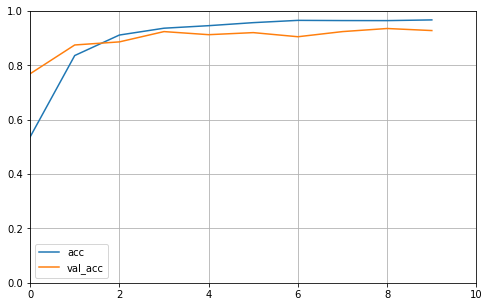

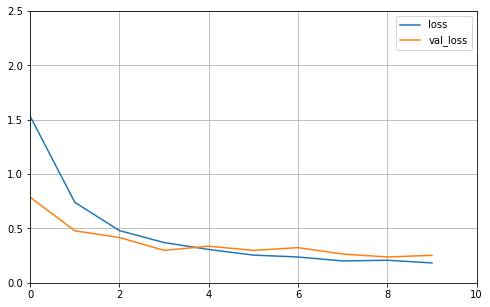

In [33]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data={}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0,epochs,min_value,max_value])
    plt.show()
    
plot_learning_curves(history,'acc',epochs,0,1)
plot_learning_curves(history,'loss',epochs,0,2.5)

In [32]:
# 实现可以训练最后几层
resnet50 = keras.applications.ResNet50(include_top=False,
                                        pooling='avg',
                                        weights='imagenet')
resnet50.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [35]:
# 对resnet50中的后五层进行遍历
for layer in resnet50.layers[0:-5]:
    layer.trainable = False
    
resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation='softmax'),
])

resnet50_new.compile(loss='categorical_crossentropy',
                          optimizer='sgd',metrics=['accuracy'])

resnet50_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 1,075,210
Non-trainable params: 22,532,992
_________________________________________________________________


In [36]:
epochs = 10
# 数据由generator产生
history = resnet50_new.fit_generator(train_generator,
                             steps_per_epoch=train_num//batch_size,
                             epochs=epochs,
                             validation_data=valid_generator,
                             validation_steps=valid_num//batch_size)



Epoch 1/10
45/45 [==============================] - 44s 974ms/step - loss: 1.3877 - acc: 0.5894 - val_loss: 0.6299 - val_acc: 0.8106
Epoch 2/10
45/45 [==============================] - 43s 947ms/step - loss: 0.5510 - acc: 0.8926 - val_loss: 0.3102 - val_acc: 0.9167
Epoch 3/10
45/45 [==============================] - 43s 962ms/step - loss: 0.3625 - acc: 0.9255 - val_loss: 0.2457 - val_acc: 0.9242
Epoch 4/10
45/45 [==============================] - 43s 946ms/step - loss: 0.2850 - acc: 0.9513 - val_loss: 0.2179 - val_acc: 0.9280
Epoch 5/10
45/45 [==============================] - 42s 933ms/step - loss: 0.2389 - acc: 0.9600 - val_loss: 0.2194 - val_acc: 0.9205
Epoch 6/10
45/45 [==============================] - 41s 910ms/step - loss: 0.1972 - acc: 0.9618 - val_loss: 0.1929 - val_acc: 0.9356
Epoch 7/10
45/45 [==============================] - 41s 914ms/step - loss: 0.1863 - acc: 0.9655 - val_loss: 0.1762 - val_acc: 0.9394
Epoch 8/10
45/45 [==============================] - 41s 904ms/step - 